In [1]:
import re
from functools import partial
from glob import glob

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
%cd '/content/drive/My Drive/Google colab Save/kaggle/2.house'

/content/drive/My Drive/Google colab Save/kaggle/2.house


In [4]:
! pip install japanize-matplotlib

     |████████████████████████████████| 4.1MB 5.3MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-cp37-none-any.whl size=4120276 sha256=eedbd7b922601d02c7e087f9deef9d1fafe4782ad8281c3734313de8bbb62761
  Stored in directory: /root/.cache/pip/wheels/b7/d9/a2/f907d50b32a2d2008ce5d691d30fb6569c2c93eefcfde55202
Successfully built japanize-matplotlib


In [5]:
import japanize_matplotlib

## Data Preparation
### Read CSV

In [6]:
paths = glob('data/train/*')
train_dfs = []
for path in paths:
    train_df = pd.read_csv(path)
    train_dfs.append(train_df)
train_df = pd.concat(train_dfs)
train_df.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
train_df.head()

ID        種類  地域  市区町村コード  ...        取引時点   改装 取引の事情等 取引価格（総額）_log
0  36000732  中古マンション等 NaN    36201  ...  2019年第１四半期  改装済    NaN     7.041393
1  36017660  中古マンション等 NaN    36201  ...  2013年第４四半期  改装済    NaN     7.079181
2  36002389  中古マンション等 NaN    36201  ...  2015年第２四半期  未改装    NaN     7.255273
3  36002867  中古マンション等 NaN    36201  ...  2018年第１四半期  未改装    NaN     7.431364
4  36001885  中古マンション等 NaN    36201  ...  2016年第２四半期  NaN    NaN     7.447158

[5 rows x 28 columns]

In [11]:
test_df = pd.read_csv('data/test.csv')

df = pd.concat([train_df, test_df])

In [13]:
print([col for col, c in train_df.nunique().items() if c < 1])
print([col for col, c in test_df.nunique().items() if c < 1])
print([col for col, c in df.nunique().items() if c < 1])

[]
[]
[]


### Drop Null Columns and Rename

In [12]:
# drop_index = [i for i, value in enumerate(temp.isnull().sum().values.tolist()) if value==temp.shape[0]]
# temp.drop(columns=temp.columns[drop_index], axis=1, inplace=True)
train_df.dropna(axis=1, how='all', inplace=True)
test_df.dropna(axis=1, how='all', inplace=True)
df.dropna(axis=1, how='all', inplace=True)


In [15]:
col_name = ['id','cate','a_c','a_1','a_2','a_3','s_name','s_dist','r_type','area','b_year','b_const','b_use','b_use_after','plan','b_land_rate','b_floor_rate','r_date','remodel','r_info','TARGET']
col_dict = dict(zip(train_df.columns.tolist(),col_name))

train_df.rename(columns=col_dict,inplace=True)
test_df.rename(columns=col_dict,inplace=True)
df.rename(columns=col_dict,inplace=True)

In [18]:
test_df['TARGET'] = np.nan
test_df.head(2)

id      cate   a_c  a_1  ...      r_date remodel r_info TARGET
0  1000000  中古マンション等  1101  北海道  ...  2020年第２四半期     未改装    NaN    NaN
1  1000056  中古マンション等  1101  北海道  ...  2020年第１四半期     未改装    NaN    NaN

[2 rows x 21 columns]

## EDA

In [19]:
## Clean variables
## FROM NISHIKA TUTORIAL CODE

def normalize_moyori(moyori):
    if moyori == moyori:
        if moyori == '30分?60分':
            moyori = 45
        elif moyori == '1H?1H30':
            moyori = 75
        elif moyori == '1H30?2H':
            moyori = 105
        elif moyori == '2H?':
            moyori = 120
        moyori = int(moyori)
    return moyori

def normalize_area(area):
    if area == area:
        area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
    return area

def convert_wareki_to_seireki(wareki):
    if wareki == wareki:
        if wareki == '戦前':
            wareki = '昭和20年'
        value = wareki[2:-1]
        if value == '元':
            value = 1
        else:
            value = int(value)
        if '昭和' in wareki:
            seireki = 1925+value
        elif '平成' in wareki:
            seireki = 1988+value
        elif '令和' in wareki:
            seireki = 2018+value
    else:
        seireki = wareki
    return seireki

def extract_r_year(r_date):
    if r_date == r_date:
      r_year = r_date[:4]
    return int(r_year)

In [20]:
df['s_dist'] = df['s_dist'].apply(lambda x : normalize_moyori(x))
df['b_year'] = df['b_year'].apply(lambda x : convert_wareki_to_seireki(x))
df['area'] = df['area'].apply(lambda x : normalize_area(x))
df['r_year'] = df['r_date'].apply(lambda x : extract_r_year(x))

df.head()

id      cate    a_c  a_1  ... remodel r_info    TARGET  r_year
0  36000732  中古マンション等  36201  徳島県  ...     改装済    NaN  7.041393    2019
1  36017660  中古マンション等  36201  徳島県  ...     改装済    NaN  7.079181    2013
2  36002389  中古マンション等  36201  徳島県  ...     未改装    NaN  7.255273    2015
3  36002867  中古マンション等  36201  徳島県  ...     未改装    NaN  7.431364    2018
4  36001885  中古マンション等  36201  徳島県  ...     NaN    NaN  7.447158    2016

[5 rows x 22 columns]

In [21]:
new_df = df.drop(columns=['cate','r_date'])
train_df = new_df[~new_df['TARGET'].isnull()]
train_df

id    a_c  a_1  a_2  ... remodel r_info    TARGET r_year
0       36000732  36201  徳島県  徳島市  ...     改装済    NaN  7.041393   2019
1       36017660  36201  徳島県  徳島市  ...     改装済    NaN  7.079181   2013
2       36002389  36201  徳島県  徳島市  ...     未改装    NaN  7.255273   2015
3       36002867  36201  徳島県  徳島市  ...     未改装    NaN  7.431364   2018
4       36001885  36201  徳島県  徳島市  ...     NaN    NaN  7.447158   2016
...          ...    ...  ...  ...  ...     ...    ...       ...    ...
637346  13282533  13113  東京都  渋谷区  ...     改装済    NaN  7.518514   2008
637347  13354602  13208  東京都  調布市  ...     改装済    NaN  7.301030   2010
637348  13192839  13121  東京都  足立区  ...     改装済    NaN  7.322219   2017
637349  13345188  13119  東京都  板橋区  ...     改装済    NaN  7.477121   2008
637350  13059919  13103  東京都   港区  ...     改装済    NaN  7.491362   2014

[637351 rows x 20 columns]

In [25]:
new_df.set_index('id', inplace=True)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 656817 entries, 36000732 to 47007421
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   a_c           656817 non-null  int64  
 1   a_1           656817 non-null  object 
 2   a_2           656817 non-null  object 
 3   a_3           656523 non-null  object 
 4   s_name        654185 non-null  object 
 5   s_dist        633759 non-null  float64
 6   r_type        634153 non-null  object 
 7   area          656817 non-null  int64  
 8   b_year        637921 non-null  float64
 9   b_const       641624 non-null  object 
 10  b_use         604694 non-null  object 
 11  b_use_after   293530 non-null  object 
 12  plan          637908 non-null  object 
 13  b_land_rate   633893 non-null  float64
 14  b_floor_rate  633893 non-null  float64
 15  remodel       597467 non-null  object 
 16  r_info        18427 non-null   object 
 17  TARGET        637351 non-null  float64


## Missing Value
- 'r_info' and 'b_use_after' have many missing values over 50%
- I want to check them
> The rows having 'r_info' seems to have different distribution, but 97%...<br>I will drop it.

> I am not sure the effect for replacing all 'b_use_after' null to 'N'.

In [26]:
total = new_df.isnull().sum().sort_values(ascending=False)
percent = (new_df.isnull().sum()/new_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

Total   Percent
r_info        638390  0.971945
b_use_after   363287  0.553102
remodel        59350  0.090360
b_use          52123  0.079357
s_dist         23058  0.035106
b_floor_rate   22924  0.034902
b_land_rate    22924  0.034902
r_type         22664  0.034506
TARGET         19466  0.029637
plan           18909  0.028789
b_year         18896  0.028769
b_const        15193  0.023131
s_name          2632  0.004007
a_3              294  0.000448
a_2                0  0.000000
a_1                0  0.000000
r_year             0  0.000000
area               0  0.000000
a_c                0  0.000000

In [28]:
def cate_nume_plot(col):
  plt.figure(figsize=(20,10))

  plt.subplot(1,2,1)
  sns.boxplot(data=train_df, x=col, y='TARGET',palette='pastel')

  plt.subplot(1,2,2)
  sns.swarmplot(data=train_df.sample(n=5000), x=col, y='TARGET',palette='pastel')
  plt.show()

In [29]:
new_df['r_info'].unique()

array([nan, '調停・競売等', '関係者間取引', 'その他事情有り', '瑕疵有りの可能性', '調停・競売等、瑕疵有りの可能性',
       '他の権利・負担付き', '関係者間取引、調停・競売等', '関係者間取引、瑕疵有りの可能性',
       '他の権利・負担付き、調停・競売等'], dtype=object)

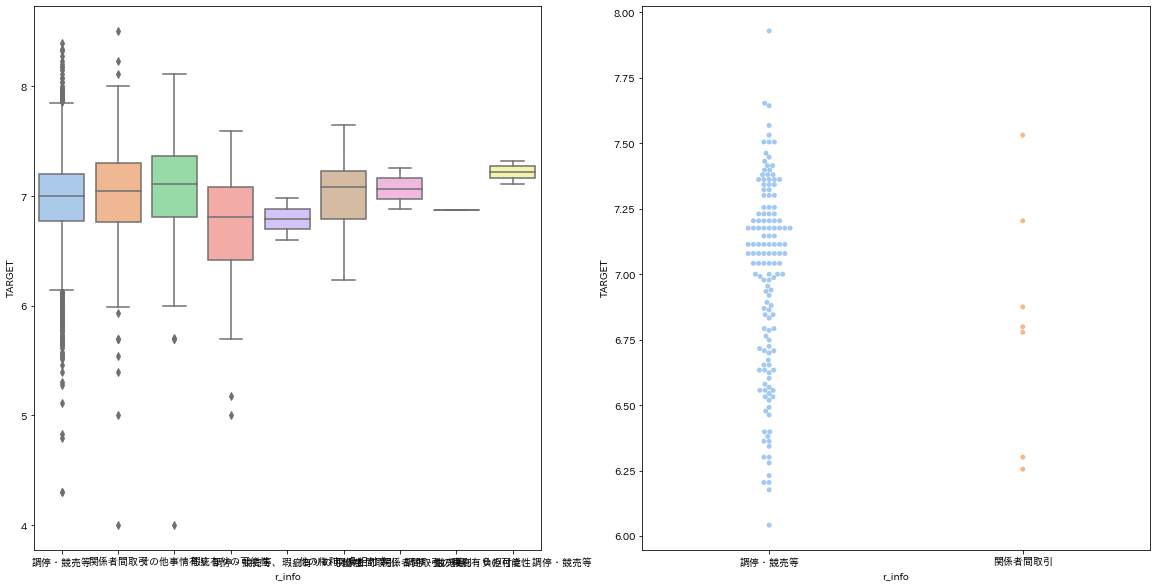

In [30]:
cate_nume_plot('r_info')

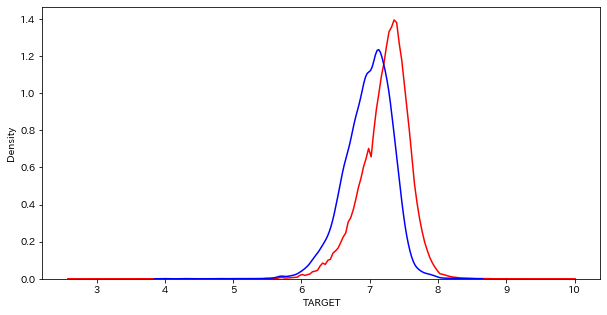

In [34]:
r_info_null = new_df['r_info'].isnull()
plt.figure(figsize=(10,5))
sns.kdeplot(data=new_df[r_info_null], x='TARGET', c='r')
sns.kdeplot(data=new_df[~r_info_null], x='TARGET', c='b')

In [38]:
new_df.drop(['r_info'], axis='columns',inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 60.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


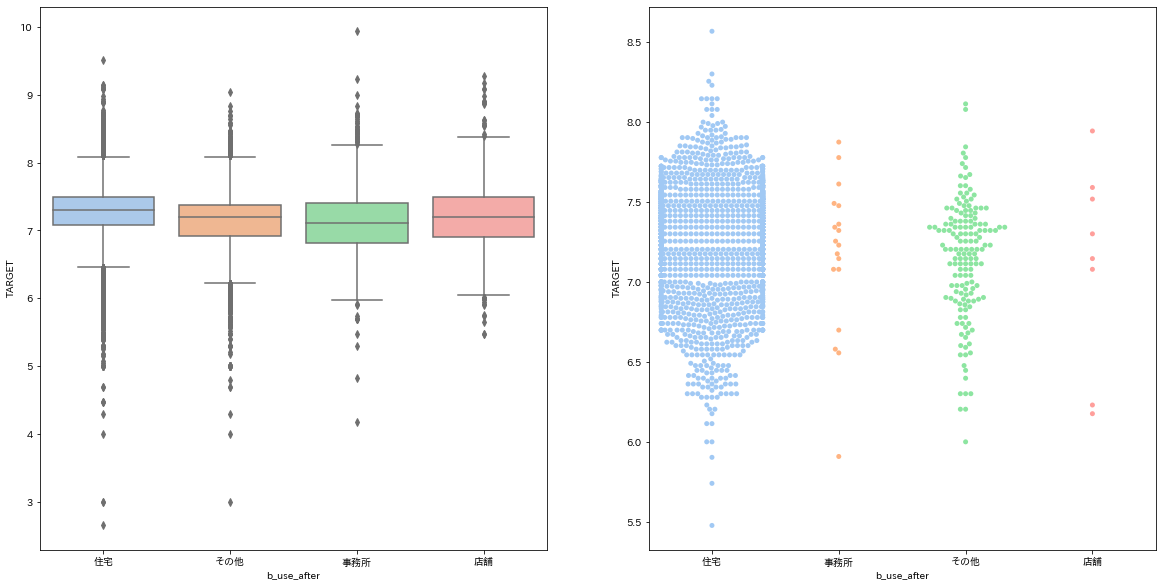

In [41]:
cate_nume_plot('b_use_after')

In [ ]:
b_use_after_null = new_df['b_use_after'].isnull
new_df[b_use_after_null]['b_use_a']

<Figure size 1080x720 with 0 Axes>

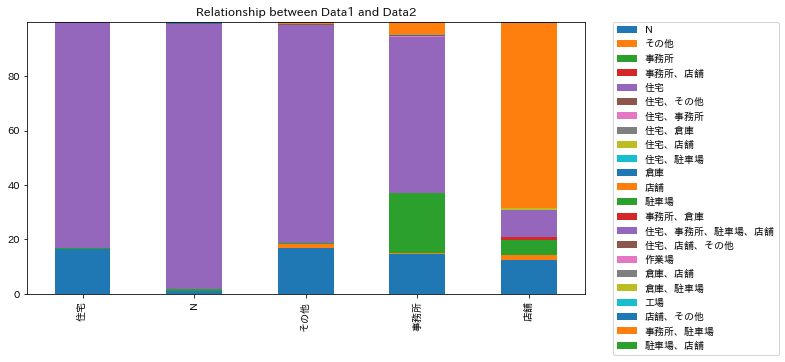

In [99]:
Group_N = 'b_use_after'
Data_N = 'b_use'

temp_df = new_df.fillna('N')
temp_list = temp_df[Group_N].unique().tolist()

temp_1 = temp_df.groupby([Group_N,Data_N]).a_c.count()[temp_list[0]]
temp_2 = temp_df.groupby([Group_N,Data_N]).a_c.count()[temp_list[1]]
temp_3 = temp_df.groupby([Group_N,Data_N]).a_c.count()[temp_list[2]]
temp_4 = temp_df.groupby([Group_N,Data_N]).a_c.count()[temp_list[3]]
temp_5 = temp_df.groupby([Group_N,Data_N]).a_c.count()[temp_list[4]]

temp_df = pd.DataFrame([temp_1,temp_2,temp_3,temp_4,temp_5])
temp_df.index = temp_list
temp_df.fillna(0, inplace=True)
## Percentage 情報に変える
temp_df = temp_df.apply(lambda row: row*100/sum(row), axis=1)

plt.figure(figsize=(15,10))
temp_df.plot(kind='bar',stacked=True,legend=True,figsize=(10,5),title='Relationship between Data1 and Data2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [104]:
new_df[['b_use','b_use_after']] = new_df[['b_use','b_use_after']].fillna('N')

In [106]:
total = new_df.isnull().sum().sort_values(ascending=False)
percent = (new_df.isnull().sum()/new_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

Total   Percent
remodel       59350  0.090360
s_dist        23058  0.035106
b_floor_rate  22924  0.034902
b_land_rate   22924  0.034902
r_type        22664  0.034506
TARGET        19466  0.029637
plan          18909  0.028789
b_year        18896  0.028769
b_const       15193  0.023131
s_name         2632  0.004007
a_3             294  0.000448
a_1               0  0.000000
a_2               0  0.000000
r_year            0  0.000000
area              0  0.000000
b_use             0  0.000000
b_use_after       0  0.000000
a_c               0  0.000000

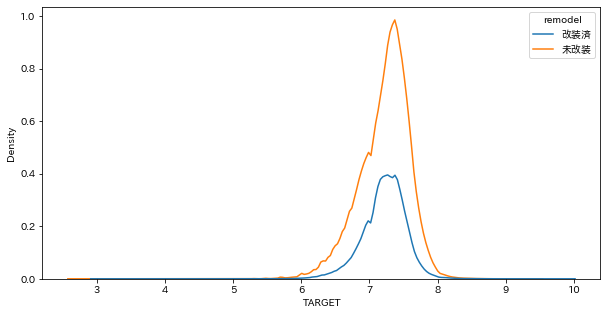

In [113]:
plt.figure(figsize=(10,5))
sns.kdeplot(data=new_df,x='TARGET',hue='remodel')

In [136]:
new_df.groupby(['remodel','b_use_after']).a_c.count()

remodel  b_use_after
改装済      N               91653
         その他              1805
         事務所               767
         住宅              71993
         店舗                215
未改装      N              243550
         その他             12193
         事務所              2112
         住宅             172464
         店舗                715
Name: a_c, dtype: int64

In [148]:
new_df.groupby(['remodel','b_use_after']).a_c.count()

temp_df = new_df.fillna('N')
temp_list = temp_df['remodel'].unique().tolist()

temp_1 = temp_df.groupby(['remodel','b_use_after']).a_c.count()[temp_list[0]]
temp_2 = temp_df.groupby(['remodel','b_use_after']).a_c.count()[temp_list[1]]

In [149]:
temp_df = pd.DataFrame([temp_1,temp_2])
temp_df.index = temp_list
temp_df.fillna(0, inplace=True)
## Percentage 情報に変える
# temp_df = temp_df.apply(lambda row: row*100/sum(row), axis=1)

plt.figure(figsize=(15,10))
temp_df.plot(kind='bar',stacked=True,legend=True,figsize=(10,5),title='Relationship between Data1 and Data2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

ValueError: ignored

In [150]:
temp_df

b_use_after       N    その他   事務所      住宅   店舗
a_c           91653   1805   767   71993  215
a_c          243550  12193  2112  172464  715

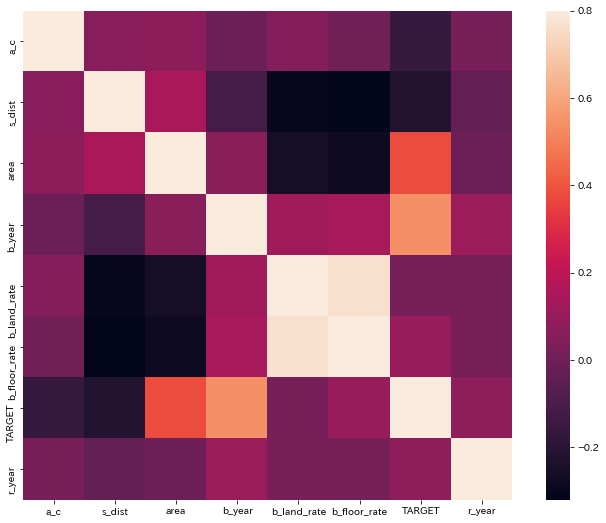

In [ ]:
corrmat = train_df.drop(columns=['id']).corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [ ]:
sns.jointplot(data=)

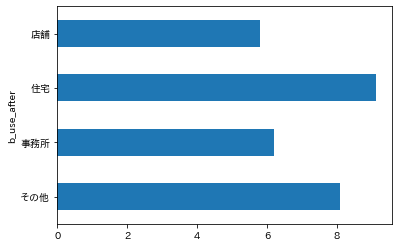

In [122]:
s_dist_under_30 = train_df['s_dist']<31
temp_df = train_df[s_dist_under_30].groupby('b_use_after').s_dist.mean()

temp_df.plot.barh()

### Numerical and Numerical

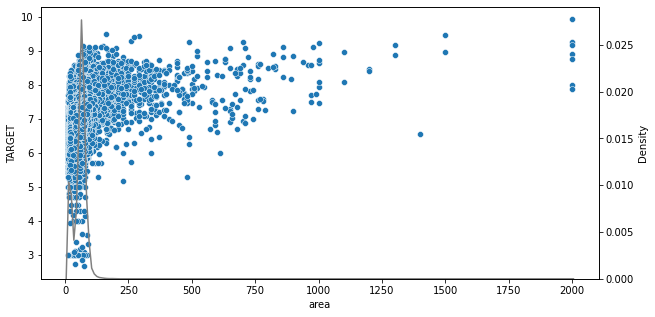

In [ ]:
## area of house AND TARGET

plt.figure(figsize=(10,5))
sns.scatterplot(data=train_df, x='area', y='TARGET')
ax2 = plt.twinx()
sns.kdeplot(data=train_df,x='area',palette='pastel',ax=ax2,color='gray')


(-10.0, 200.0)

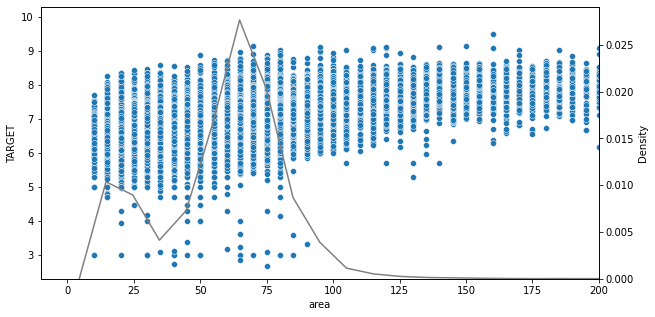

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=train_df, x='area', y='TARGET')
ax2 = plt.twinx()
sns.kdeplot(data=train_df,x='area',palette='pastel',ax=ax2,color='gray')
plt.xlim(-10,200)

In [ ]:
temp_df = train_df[['area','TARGET']]
temp_df.head()

area    TARGET
0    35  6.812913
1    45  6.623249
2    65  7.447158
3    85  7.278754
4    65  7.146128

In [ ]:
def divide_area(area):
  if area < 30:
    a_level = 1
  elif area < 60:
    a_level = 2
  elif area < 90:
    a_level = 3
  else:
    a_level = 4
  return a_level

temp_df['a_level'] = temp_df['area'].apply(lambda x : divide_area(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


(5.0, 10.0)

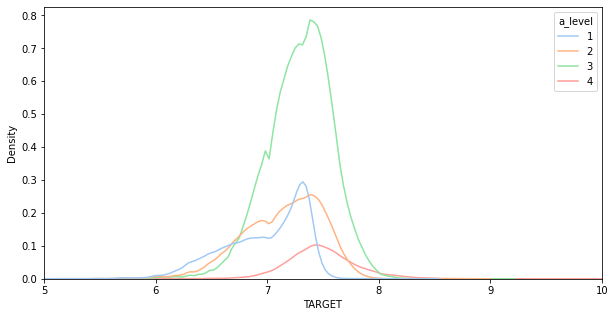

In [ ]:
plt.figure(figsize=(10,5))
sns.kdeplot(data=temp_df, x='TARGET', hue='a_level',palette='pastel')
plt.xlim(5,10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


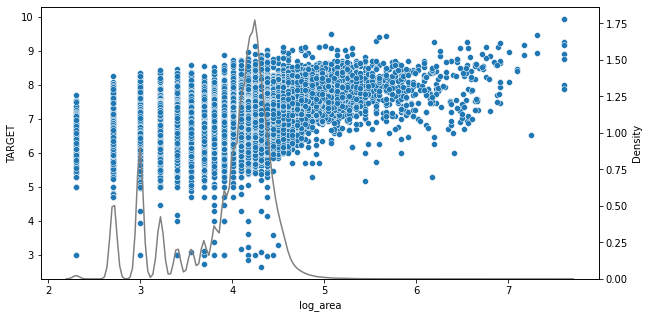

In [ ]:
temp_df['log_area'] = train_df['area'].apply(lambda x : np.log(x))

plt.figure(figsize=(10,5))
sns.scatterplot(data=temp_df, x='log_area', y='TARGET')
ax2 = plt.twinx()
sns.kdeplot(data=temp_df,x='log_area',palette='pastel',ax=ax2,color='gray')

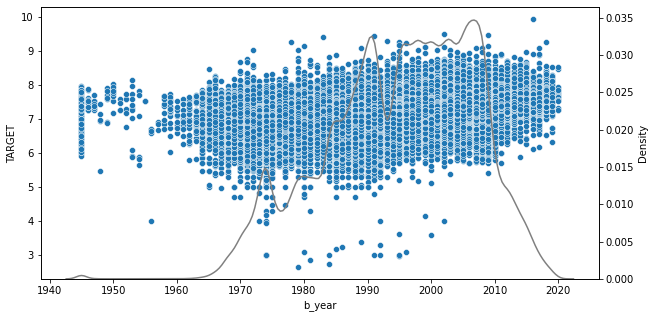

In [ ]:
## area of house AND TARGET

plt.figure(figsize=(10,5))
sns.scatterplot(data=train_df, x='b_year', y='TARGET')
ax2 = plt.twinx()
sns.kdeplot(data=train_df,x='b_year',palette='pastel',ax=ax2,color='gray')

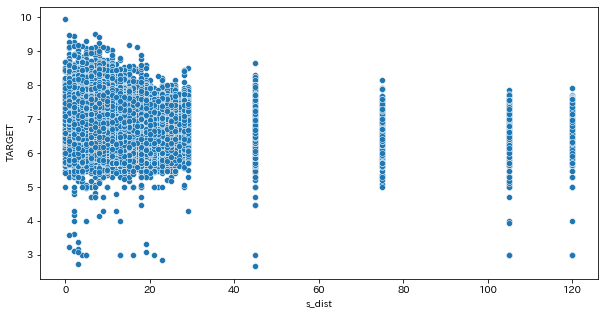

In [114]:
## Distance from the nearest station AND TARGET

plt.figure(figsize=(10,5))
sns.scatterplot(data=train_df, x='s_dist', y='TARGET')
# plt.xlim(-1,35)

### Categorical and Numerical

In [ ]:
def cate_nume_plot(col):
  plt.figure(figsize=(20,10))

  plt.subplot(1,2,1)
  sns.boxplot(data=train_df, x=col, y='TARGET',palette='pastel')

  plt.subplot(1,2,2)
  sns.swarmplot(data=train_df.sample(n=5000), x=col, y='TARGET',palette='pastel')
  plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 79.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 73.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


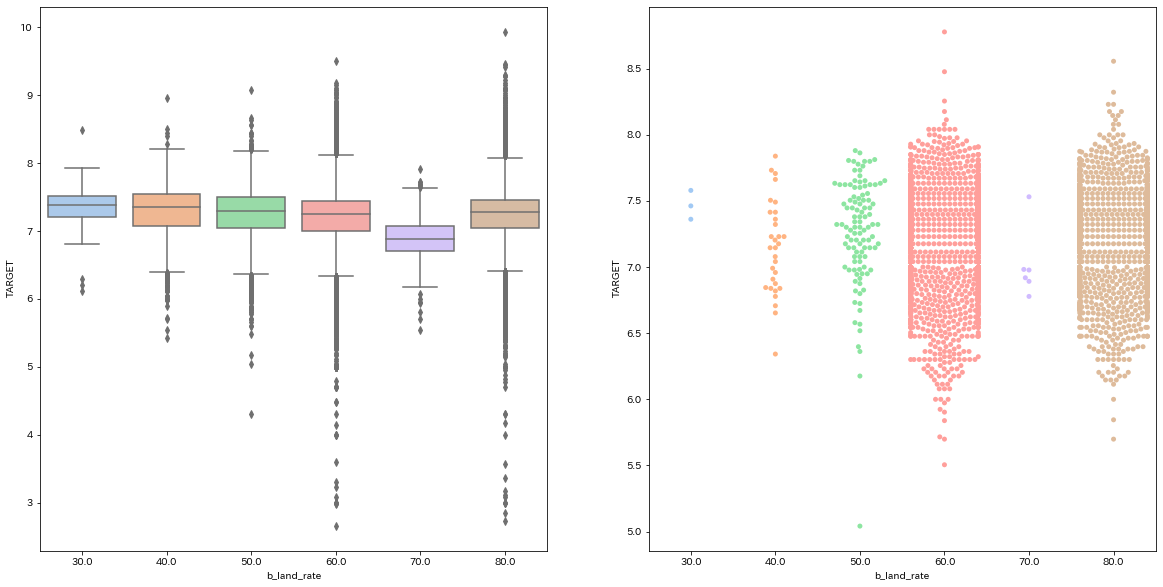

In [ ]:
cate_nume_plot('b_land_rate')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 12.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 87.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 67.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 52.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 42.9% of the points cannot be placed; y

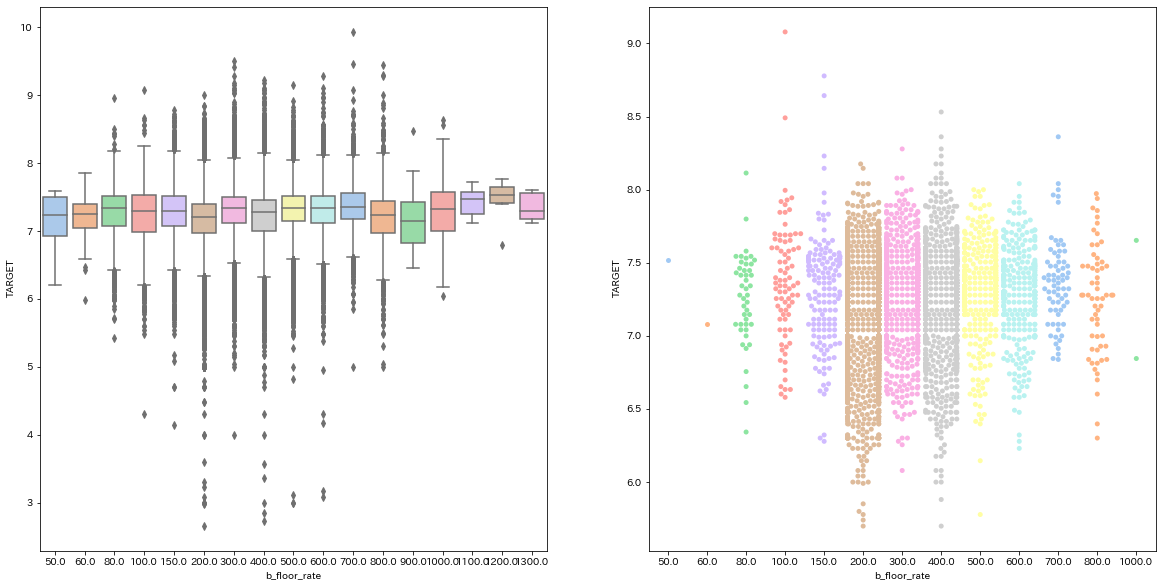

In [ ]:
cate_nume_plot('b_floor_rate')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 31.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 43.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 52.2% of the points cannot be placed; yo

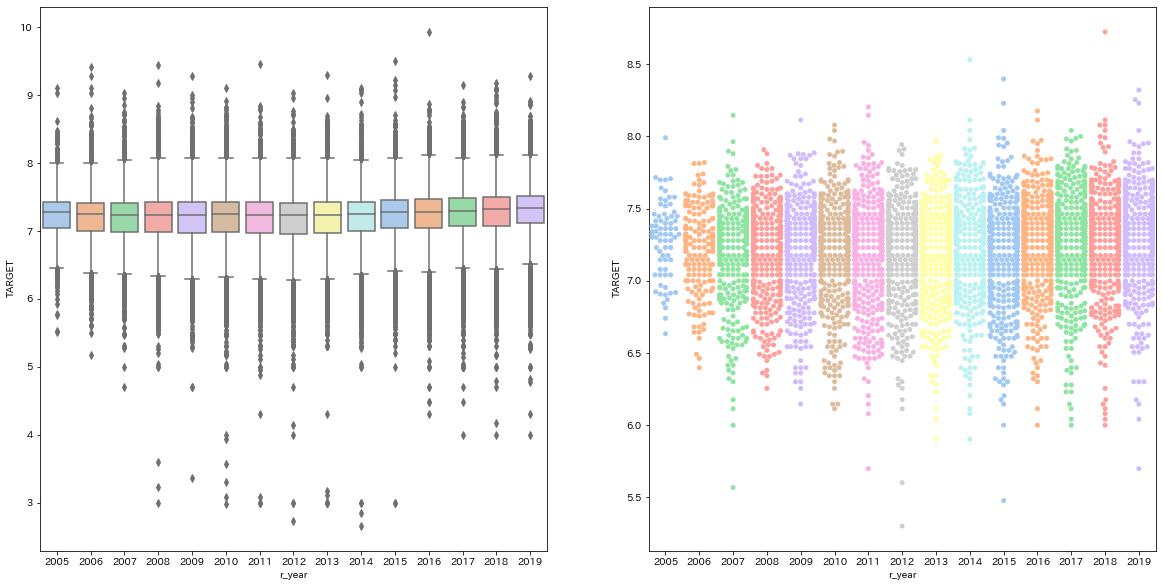

In [ ]:
cate_nume_plot('r_year')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 60.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 36.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


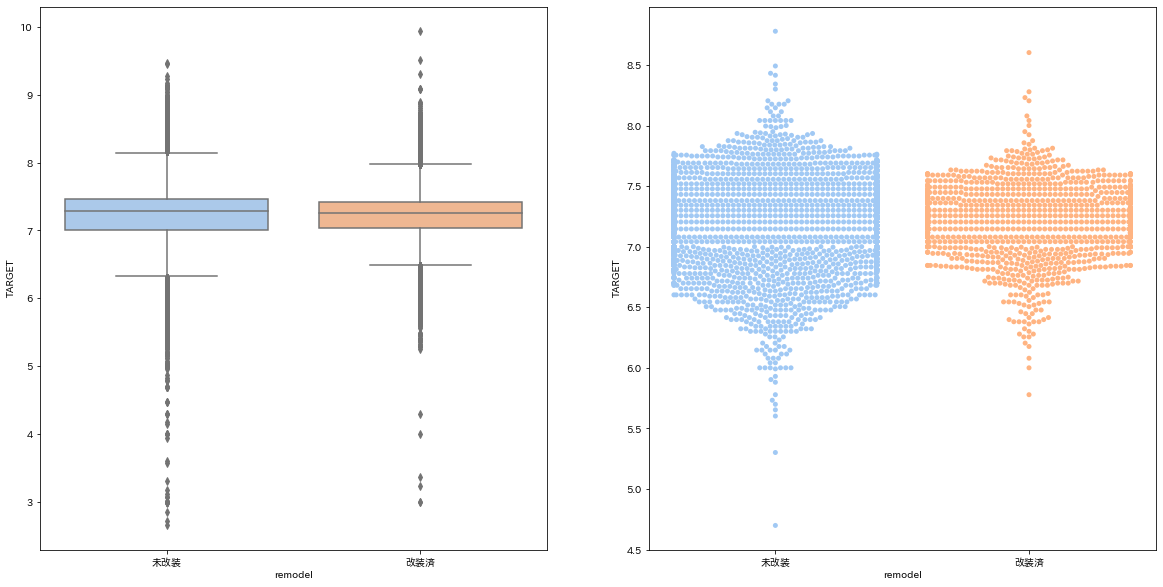

In [ ]:
cate_nume_plot('remodel')

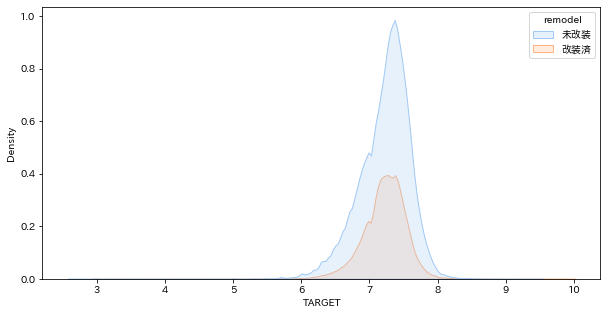

In [ ]:
plt.figure(figsize=(10,5))
sns.kdeplot(data=train_df, x='TARGET', hue='remodel', palette='pastel', shade=True)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 89.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


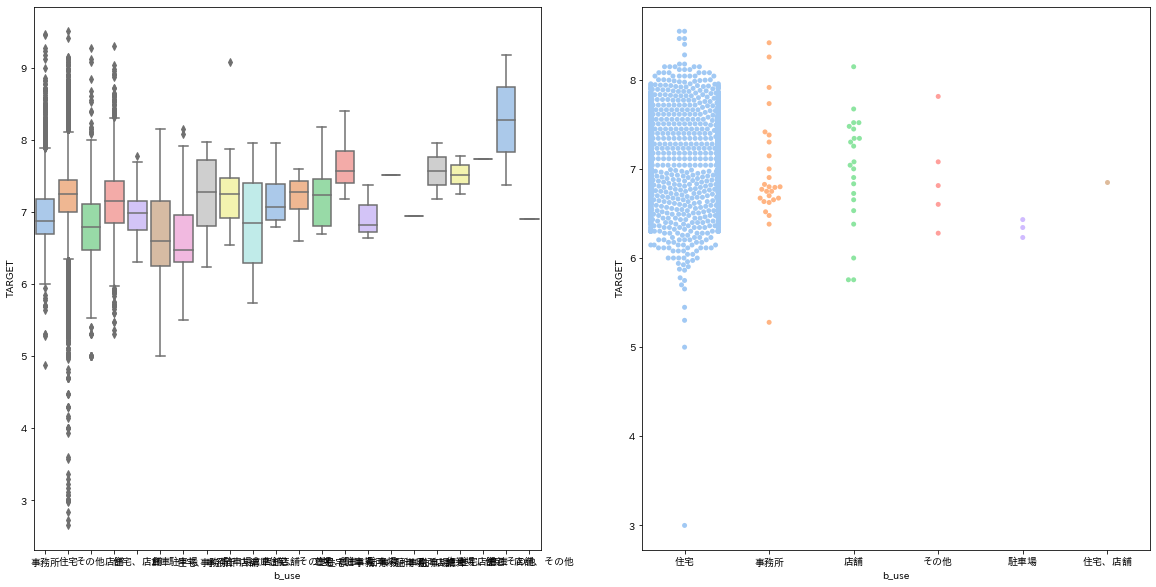

In [ ]:
cate_nume_plot('b_use')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 63.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


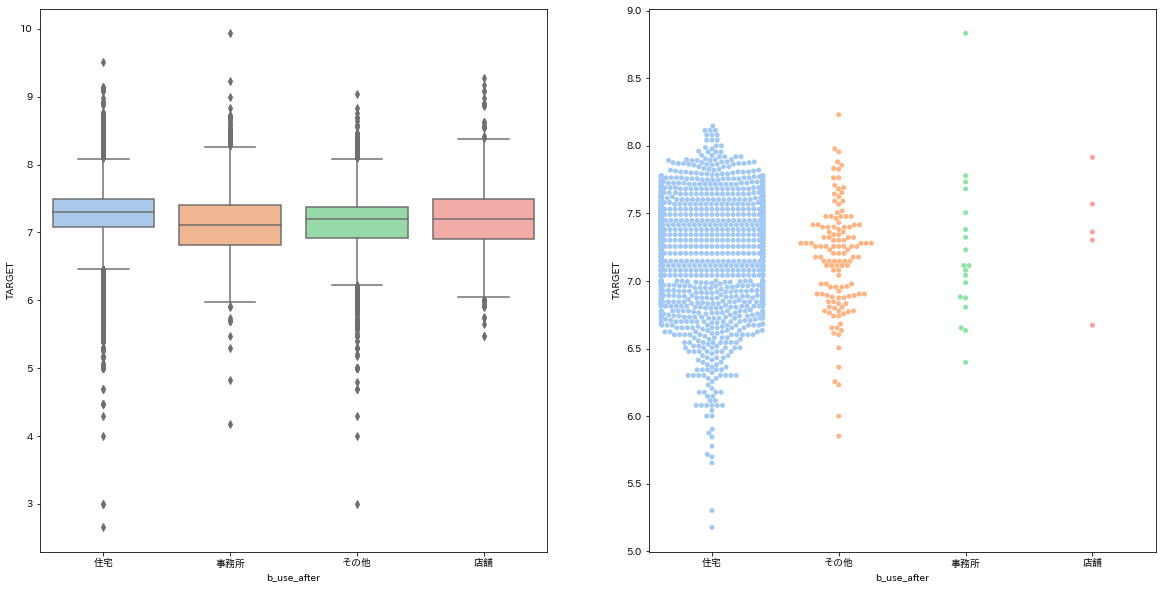

In [ ]:
cate_nume_plot('b_use_after')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 83.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 24.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 39.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 62.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 72.5% of the points cannot be placed; y

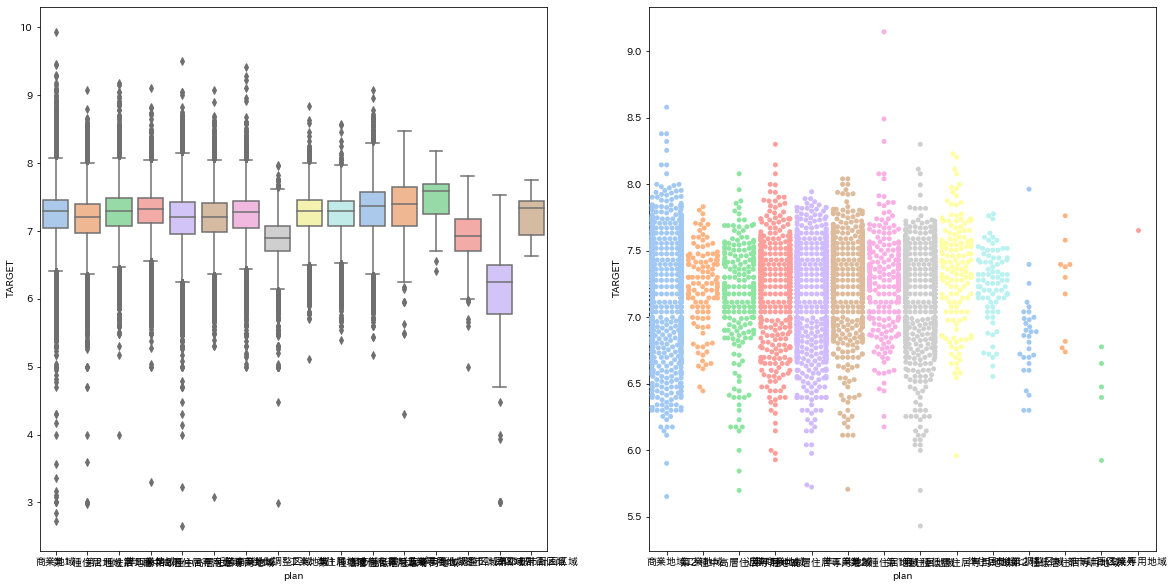

In [ ]:
cate_nume_plot('plan')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 95.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 92.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 78.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 76.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 91.6% of the points cannot be placed; y

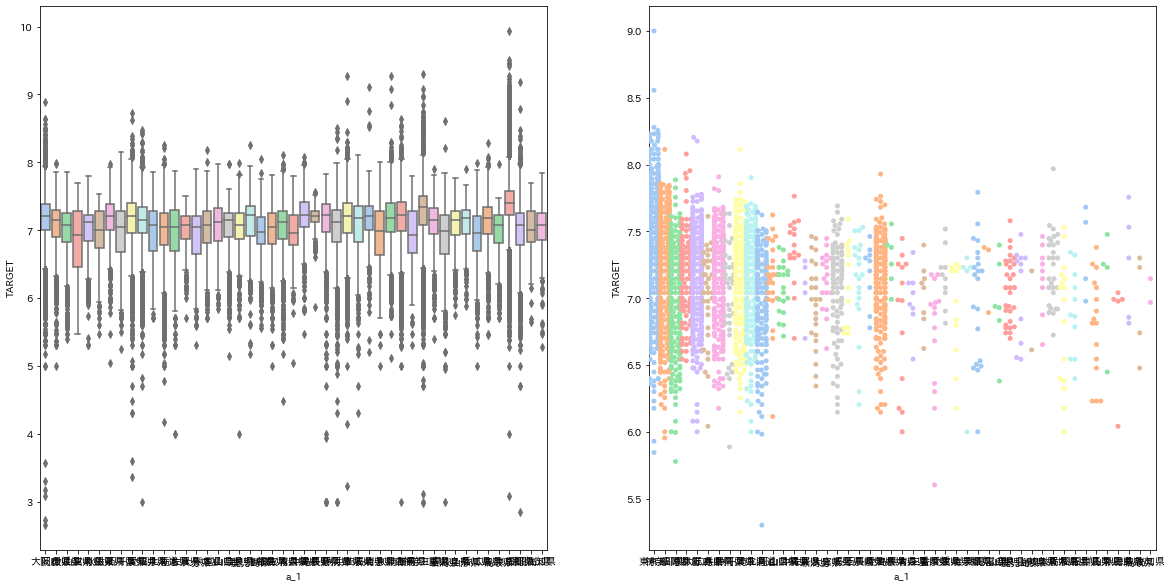

In [ ]:
cate_nume_plot('a_1')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 8.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 61.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 72.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 79.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 81.6% of the points cannot be placed; yo

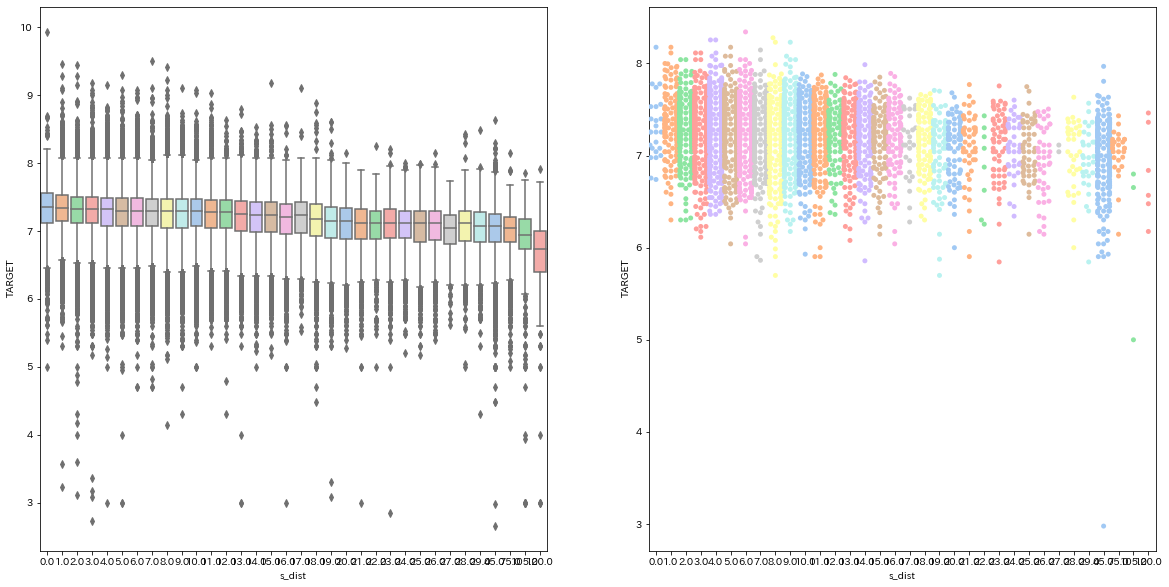

In [ ]:
cate_nume_plot('s_dist')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 95.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 85.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 63.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 36.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 85.0% of the points cannot be placed; y

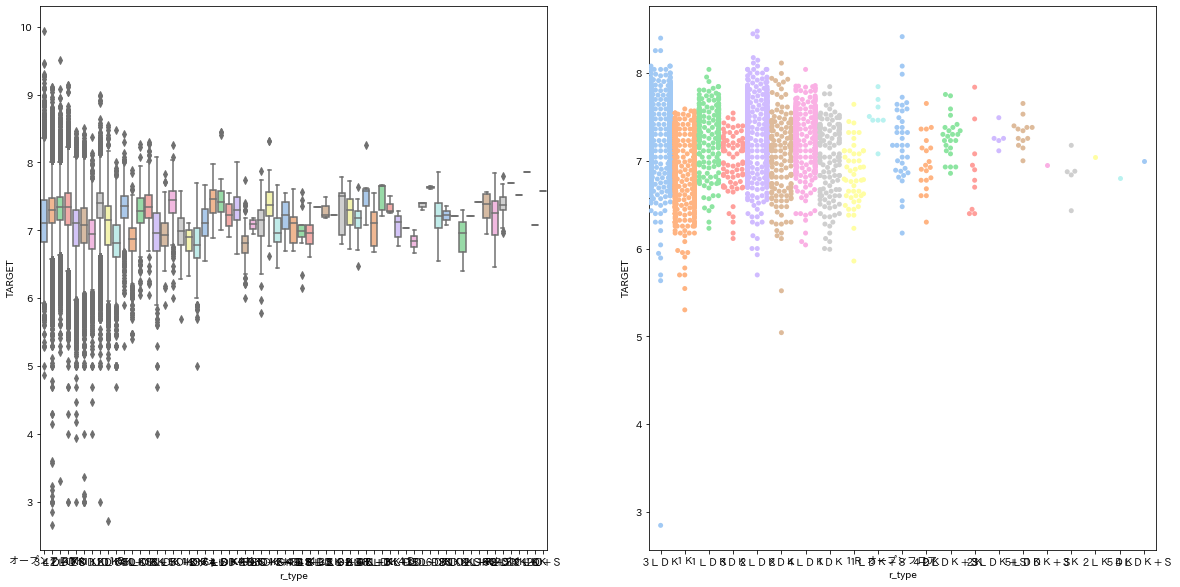

In [ ]:
cate_nume_plot('r_type')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 66.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 81.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


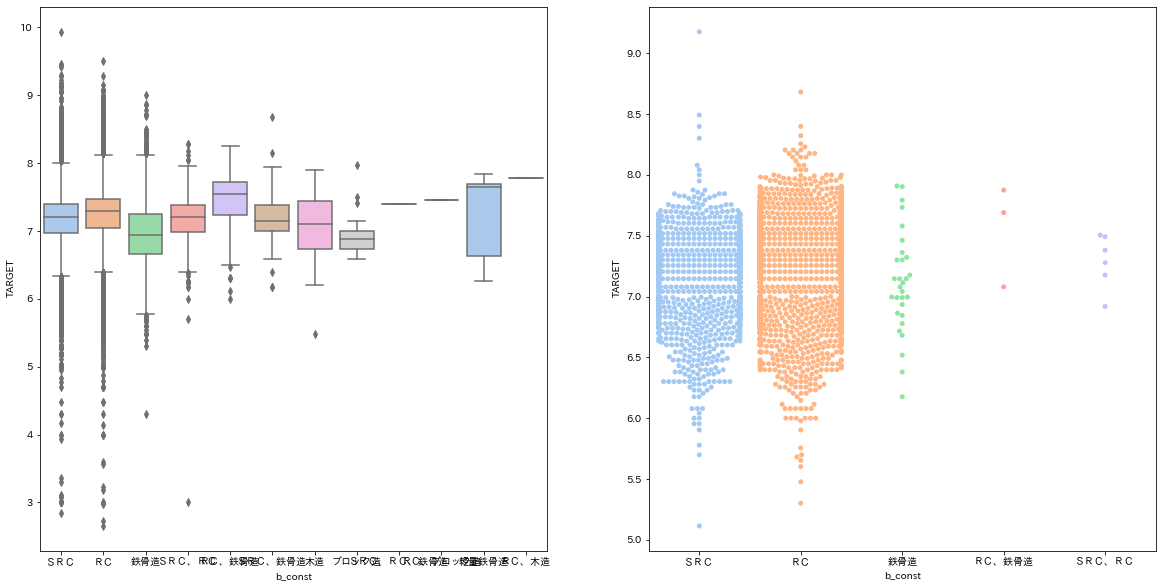

In [ ]:
cate_nume_plot('b_const')

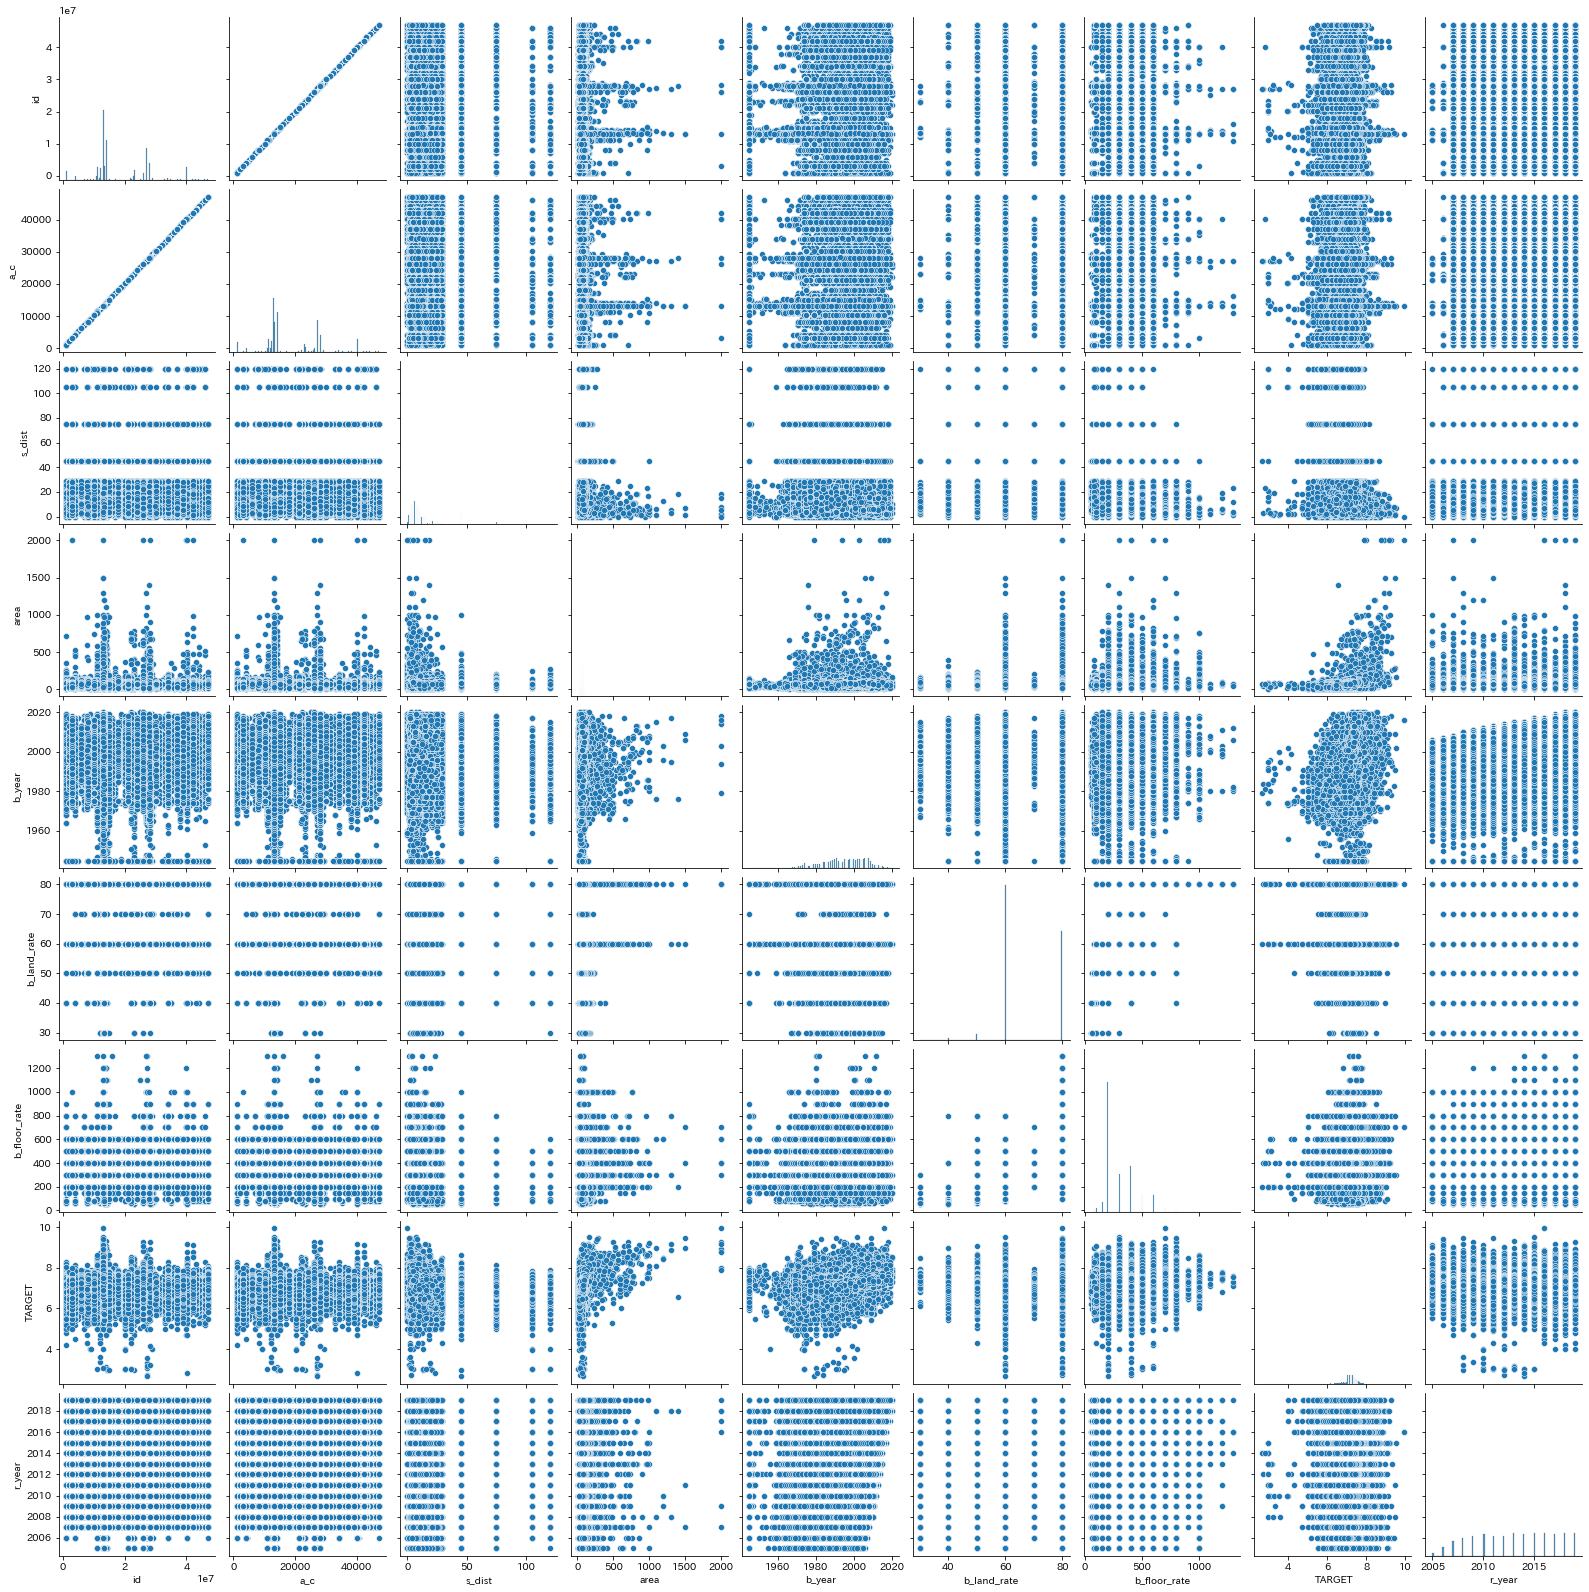

In [ ]:
sns.pairplot(train_df)

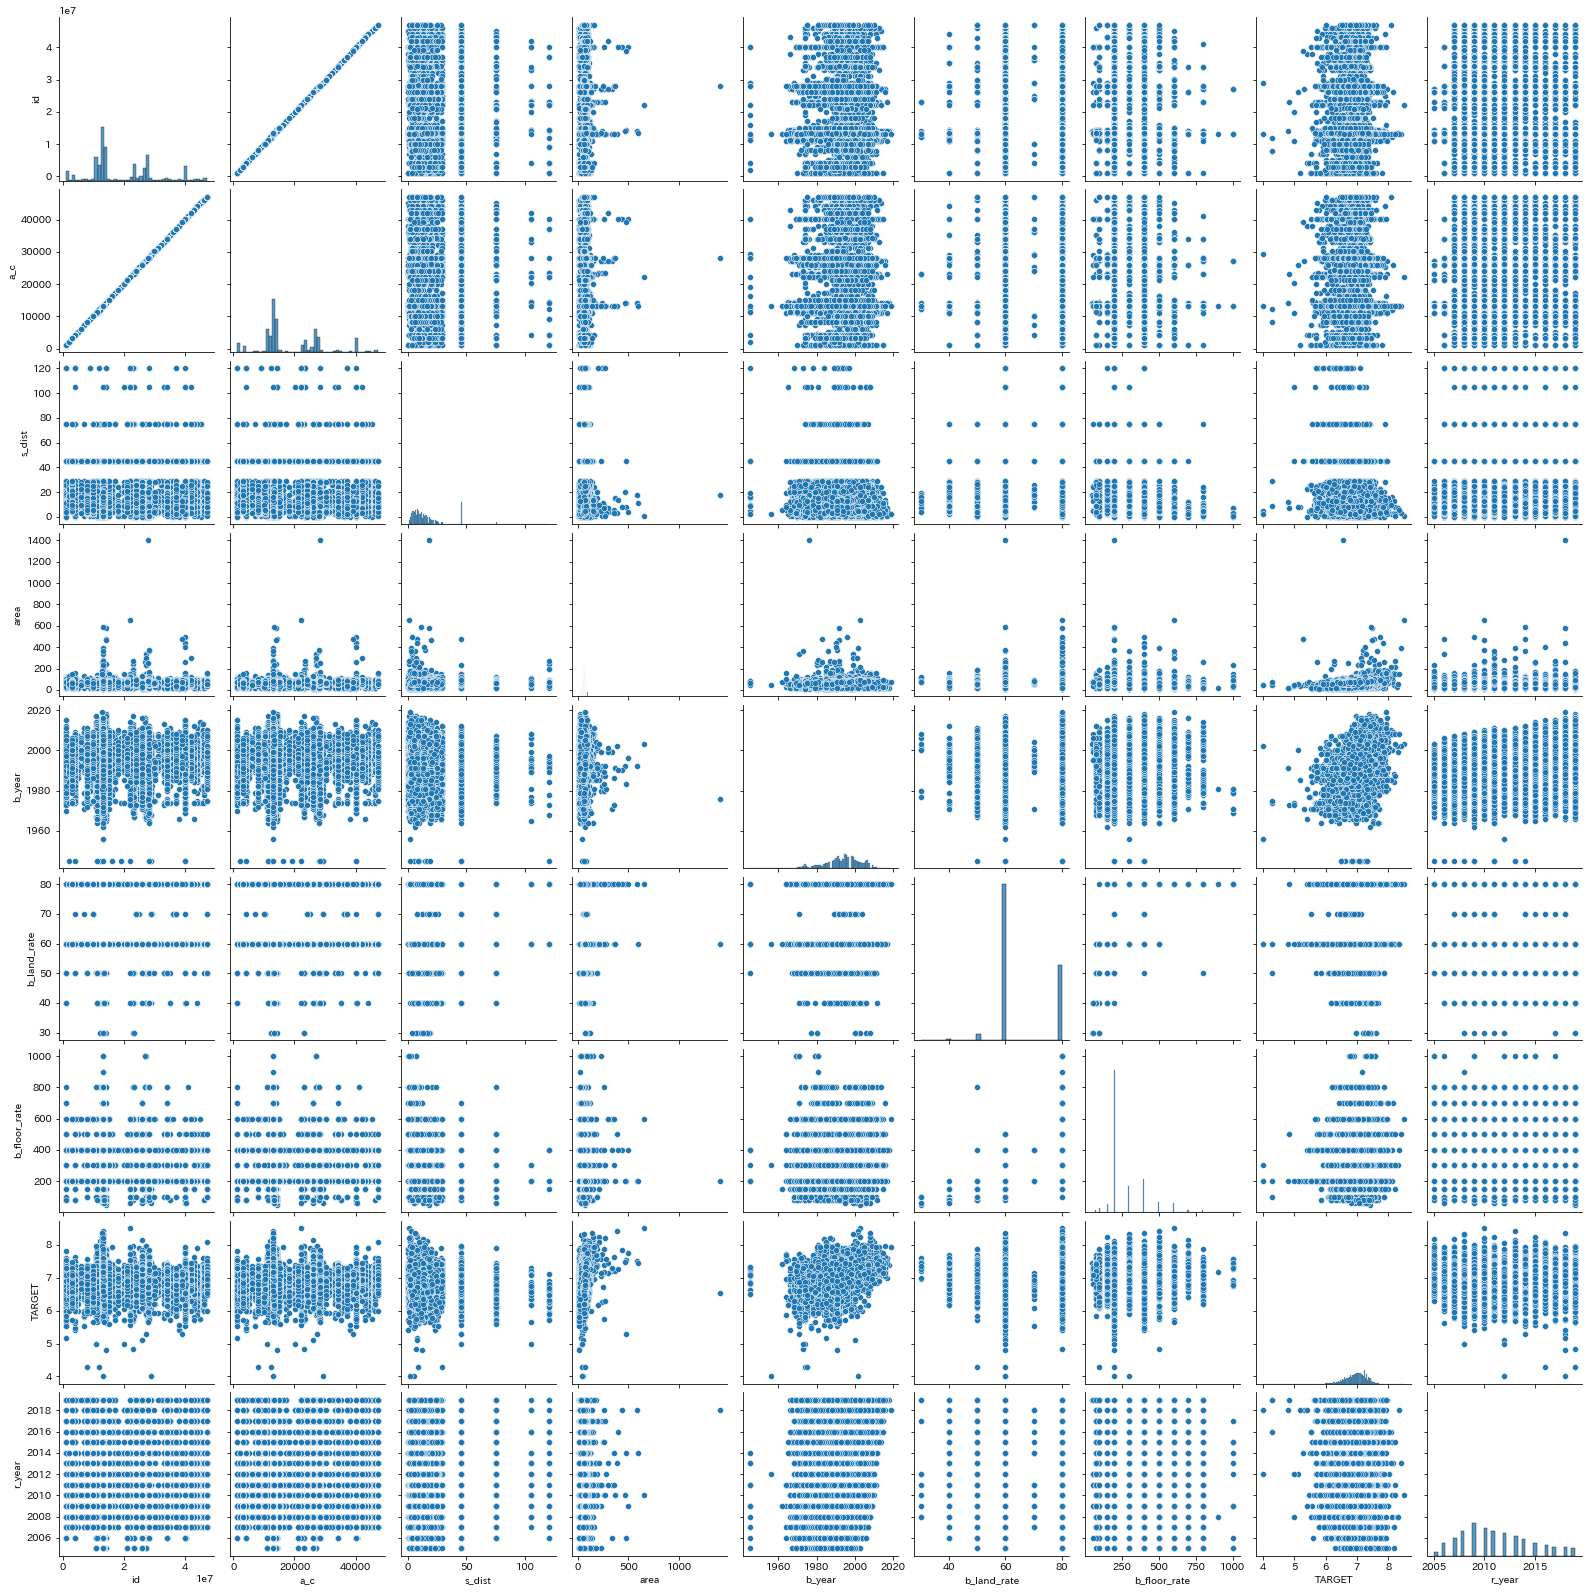

In [ ]:
temp = train_df[~train_df['r_info'].isnull()]
sns.pairplot(temp)

In [ ]:
from sklearn.preprocessing import StandardScaler

saleprice_scaled = StandardScaler().fit_transform(train_df['TARGET'][:,np.newaxis])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-12.89564112]
 [-12.69485999]
 [-12.35349118]
 [-11.97877328]
 [-11.94062364]
 [-11.94062364]
 [-11.91583395]
 [-11.91583395]
 [-11.91583395]
 [-11.91583395]]

outer range (high) of the distribution:
[[5.68756513]
 [5.82404431]
 [5.82404431]
 [5.82404431]
 [5.88698364]
 [6.20891715]
 [6.29985118]
 [6.34290991]
 [6.46370059]
 [7.67677409]]


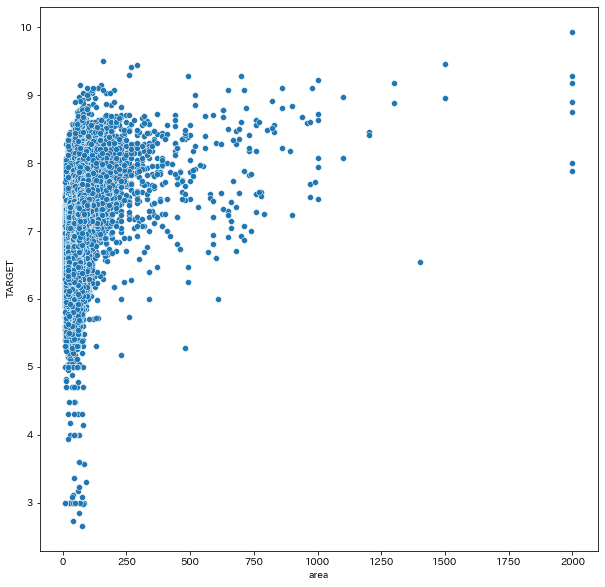

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=train_df, x='area', y='TARGET', palette='pastel')

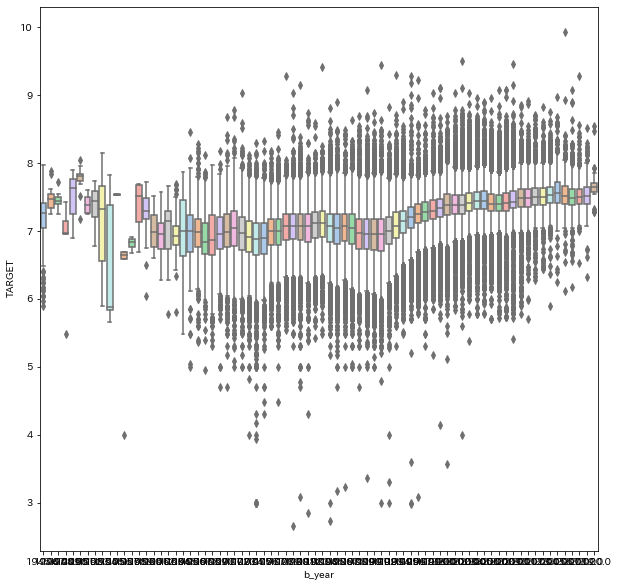

In [ ]:
plt.figure(figsize=(10,10))
sns.boxplot(data=train_df, x='b_year', y='TARGET', palette='pastel')

In [ ]:
from scipy import stats
from scipy.stats import norm

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


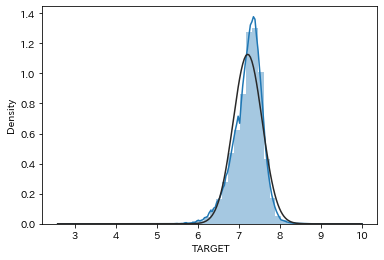

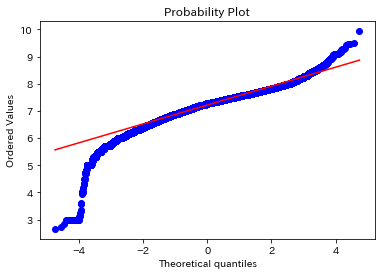

In [ ]:
sns.distplot(train_df['TARGET'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_df['TARGET'], plot=plt)

In [ ]:
temp_train = train_df

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


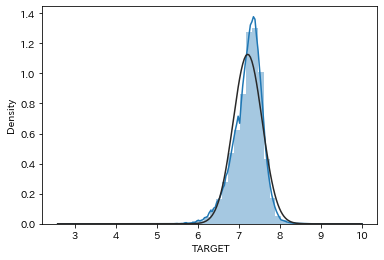

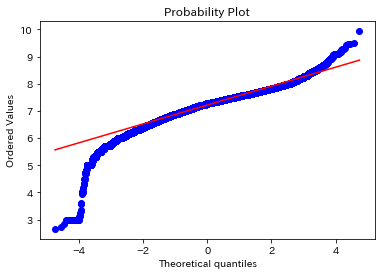

In [ ]:
sns.distplot(temp_train['TARGET'], fit=norm);
fig = plt.figure()
res = stats.probplot(temp_train['TARGET'], plot=plt)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


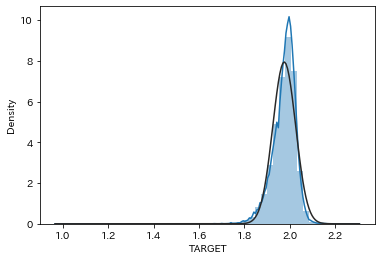

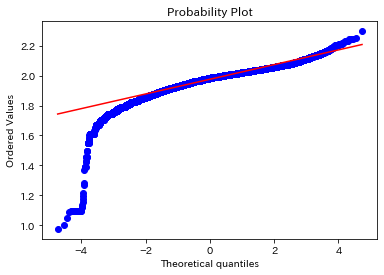

In [ ]:
temp_train['TARGET'] = np.log(temp_train['TARGET'])
sns.distplot(temp_train['TARGET'], fit=norm);
fig = plt.figure()
res = stats.probplot(temp_train['TARGET'], plot=plt)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


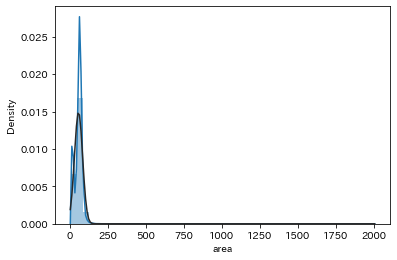

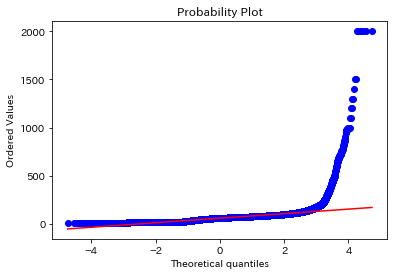

In [ ]:
sns.distplot(temp_train['area'], fit=norm);
fig = plt.figure()
res = stats.probplot(temp_train['area'], plot=plt)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


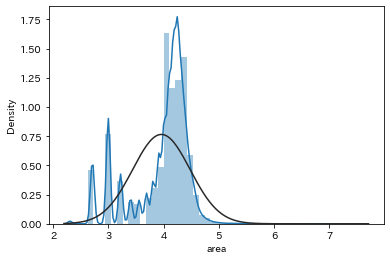

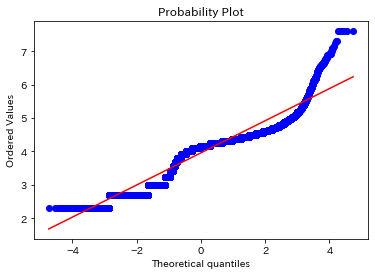

In [ ]:
temp_train['area'] = np.log(temp_train['area'])
sns.distplot(temp_train['area'], fit=norm);
fig = plt.figure()
res = stats.probplot(temp_train['area'], plot=plt)

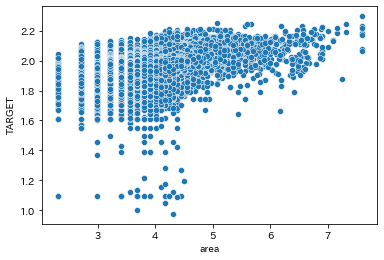

In [ ]:
sns.scatterplot(data = temp_train, x='area', y='TARGET')

In [ ]:
temp_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 637351 entries, 0 to 637350
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            637351 non-null  int64  
 1   a_c           637351 non-null  int64  
 2   a_1           637351 non-null  object 
 3   a_2           637351 non-null  object 
 4   a_3           637060 non-null  object 
 5   s_name        634732 non-null  object 
 6   s_dist        614306 non-null  float64
 7   r_type        615609 non-null  object 
 8   area          637351 non-null  float64
 9   b_year        619117 non-null  float64
 10  b_const       623423 non-null  object 
 11  b_use         591214 non-null  object 
 12  b_use_after   275091 non-null  object 
 13  plan          618786 non-null  object 
 14  b_land_rate   614848 non-null  float64
 15  b_floor_rate  614848 non-null  float64
 16  remodel       580431 non-null  object 
 17  r_info        18275 non-null   object 
 18  TARG

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


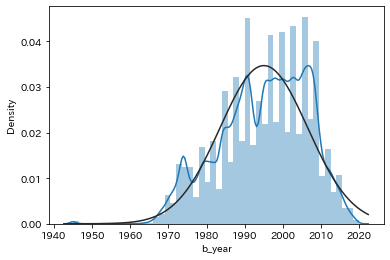

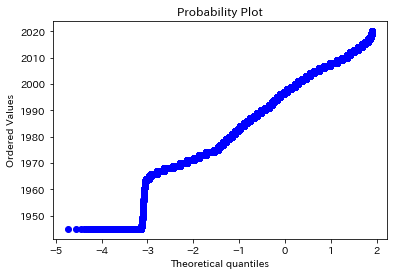

In [ ]:
sns.distplot(temp_train['b_year'], fit=norm);
fig = plt.figure()
res = stats.probplot(temp_train['b_year'], plot=plt)